In [ ]:
!pip install catboost
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier, Pool
import shap
import itertools
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d iabhishekofficial/mobile-price-classification -p /content/drive/MyDrive/Project_2

In [3]:
%cd /content/drive/MyDrive/Mobile-Price-Classification/

/content/drive/MyDrive/Mobile-Price-Classification


## Feature engineering

In [4]:
df=pd.read_csv('data.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


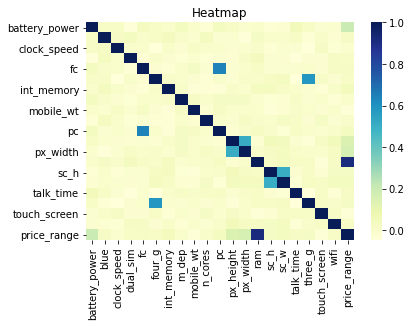

In [6]:
df_corr = df.corr() # matrix of pairwise correlations using the standard correlation coefficient
seaborn.heatmap(df_corr, cmap="YlGnBu")
seaborn.set(font_scale=1, style='white')
plt.title('Heatmap')
plt.show()

We can see that the selling price range is highly correlated with the amount of RAM. Other signifant dependencies are between the number of front camera and primary camera mega pixels, supportance of 3G and 4G, pixel resolution height and width, and screen height and width.

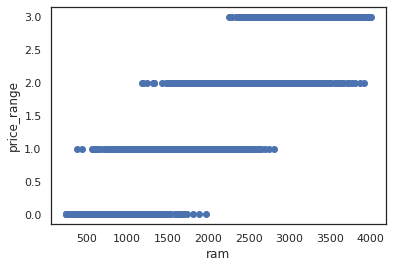

In [7]:
plt.scatter(df.ram, df.price_range)
plt.xlabel('ram')
plt.ylabel('price_range')
plt.show()

We now aim to modify the correlated features into uncorrelated features.

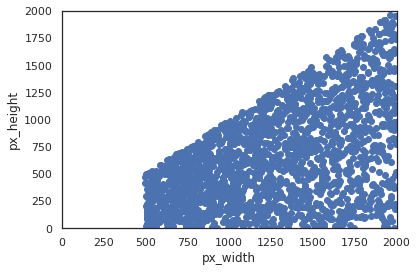

In [8]:
plt.scatter(df.px_width, df.px_height)
plt.xlabel('px_width')
plt.ylabel('px_height')
plt.xlim([0, 2000])
plt.ylim([0, 2000])
plt.show()

In the plot of px_height against px_width, the data points are evenly distributed under the line y = x, so we make a new feature by dividing px_height by px_width.

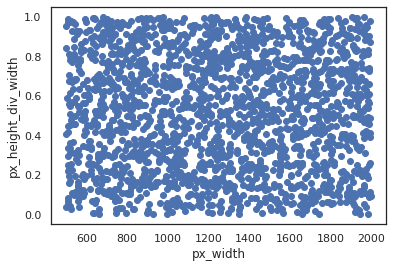

In [9]:
plt.scatter(df.px_width, df.px_height / df.px_width)
plt.xlabel('px_width')
plt.ylabel('px_height_div_width')
plt.show()

The variables px_height_div_width and px_width are approximately uncorrelated. We do the same thing for features sc_w and sc_h, and fc and pc.

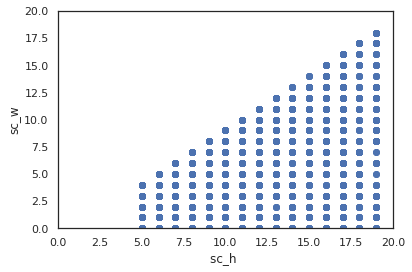

In [10]:
plt.scatter(df.sc_h , df.sc_w)
plt.xlabel('sc_h ')
plt.ylabel('sc_w')
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.show()

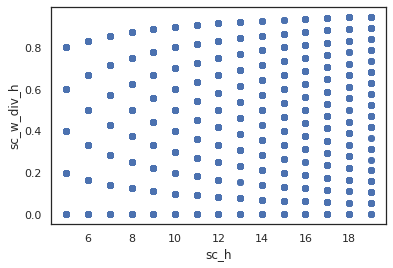

In [11]:
plt.scatter(df.sc_h , df.sc_w / df.sc_h)
plt.xlabel('sc_h')
plt.ylabel('sc_w_div_h')
plt.show()

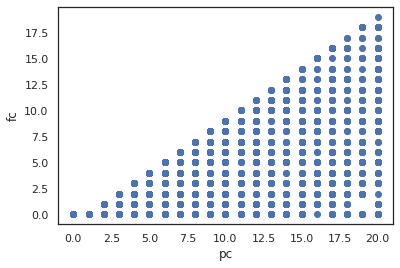

In [12]:
plt.scatter(df.pc, df.fc)
plt.xlabel('pc')
plt.ylabel('fc')
plt.show()

Below we set fc / pc = 0 for inputs with pc = 0.

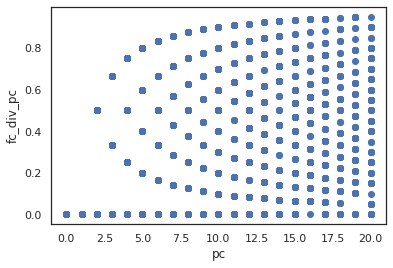

In [13]:
plt.scatter(df.pc, np.where(df.pc != 0, df.fc / df.pc, 0))
plt.xlabel('pc')
plt.ylabel('fc_div_pc')
plt.show()

Therefore, we decide to include features px_height_div_width, sc_w_div_h and fc_div_pc to the dataframe, and remove features px_height, sc_w and fc.

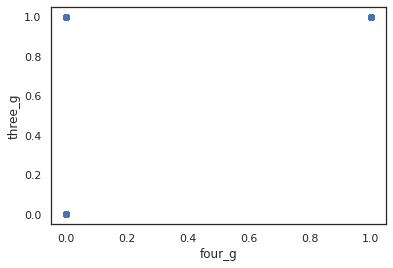

In [14]:
plt.scatter(df.four_g, df.three_g)
plt.xlabel('four_g')
plt.ylabel('three_g')
plt.show()

Mobile phones that have 4G also have 3G. We create a new feature two_g that we define to be equal to 1 if the phone supports neither 3G nor 4G, and is set to 0 otherwise. We also redefine three_g to be equal to 1 if and only if the phone supports 3G but not 4G.

In [15]:
df['px_height_div_width'] = df.px_height / df.px_width
df['sc_w_div_h'] = df.sc_w / df.sc_h
df['fc_div_pc'] = np.where(df.pc != 0, df.fc / df.pc, 0)
df['two_g'] = np.where((df['three_g'] == 0) & (df['four_g'] == 0), 1, 0)
df['three_g'] = np.where((df['three_g'] == 1) & (df['four_g'] == 0), 1, 0)
df = df.drop(['px_height','sc_w','fc'], axis=1)

In [16]:
df.head()

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_width,ram,sc_h,talk_time,three_g,touch_screen,wifi,price_range,px_height_div_width,sc_w_div_h,fc_div_pc,two_g
0,842,0,2.2,0,0,7,0.6,188,2,2,756,2549,9,19,0,0,1,1,0.026455,0.777778,0.500000,1
1,1021,1,0.5,1,1,53,0.7,136,3,6,1988,2631,17,7,0,1,0,2,0.455231,0.176471,0.000000,0
2,563,1,0.5,1,1,41,0.9,145,5,6,1716,2603,11,9,0,1,0,2,0.736014,0.181818,0.333333,0
3,615,1,2.5,0,0,10,0.8,131,6,9,1786,2769,16,11,1,0,0,2,0.680851,0.500000,0.000000,0
4,1821,1,1.2,0,1,44,0.6,141,2,14,1212,1411,8,15,0,1,0,1,0.996700,0.250000,0.928571,0


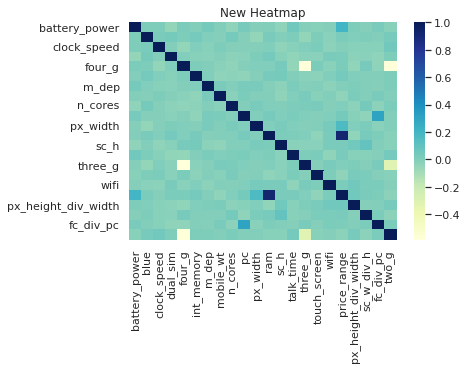

In [17]:
df_corr = df.corr()
seaborn.heatmap(df_corr, cmap="YlGnBu")
seaborn.set(font_scale=1, style='white')
plt.title('New Heatmap')
plt.show()

two_g, three_g and four_g are now disjoint categories, and there is little correlation between the other input features.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   battery_power        2000 non-null   int64  
 1   blue                 2000 non-null   int64  
 2   clock_speed          2000 non-null   float64
 3   dual_sim             2000 non-null   int64  
 4   four_g               2000 non-null   int64  
 5   int_memory           2000 non-null   int64  
 6   m_dep                2000 non-null   float64
 7   mobile_wt            2000 non-null   int64  
 8   n_cores              2000 non-null   int64  
 9   pc                   2000 non-null   int64  
 10  px_width             2000 non-null   int64  
 11  ram                  2000 non-null   int64  
 12  sc_h                 2000 non-null   int64  
 13  talk_time            2000 non-null   int64  
 14  three_g              2000 non-null   int64  
 15  touch_screen         2000 non-null   i

We split the dataset into training and test sets.

In [19]:
X = df.drop("price_range", axis=1)
y = df["price_range"].astype("category")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [20]:
X_train.head()

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_width,ram,sc_h,talk_time,three_g,touch_screen,wifi,px_height_div_width,sc_w_div_h,fc_div_pc,two_g
582,1232,0,2.9,1,1,24,0.3,169,5,17,809,1257,16,16,0,0,0,0.446230,0.625000,0.058824,0
159,1840,0,0.5,1,0,34,0.7,142,1,16,1545,1078,8,10,0,0,0,0.201294,0.000000,0.750000,1
1827,1692,0,2.1,0,1,2,0.9,106,1,17,1904,3779,9,7,0,1,1,0.997374,0.333333,0.235294,0
318,508,0,0.8,0,1,42,0.3,94,1,8,557,663,13,7,0,0,0,0.070018,0.923077,0.875000,0
708,977,1,2.8,1,0,35,0.6,165,2,15,1862,3714,19,10,0,1,1,0.806660,0.157895,0.133333,1


## Decision tree

In [21]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

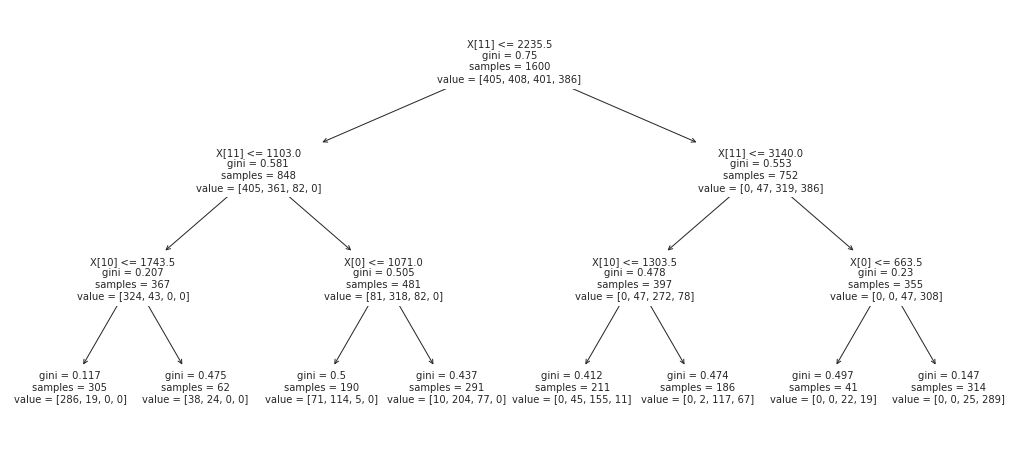

In [22]:
plt.figure(figsize=(18,8))
plot_tree(tree, fontsize=10)
plt.show()

From the decision tree we can see that excluding ram (X[11]), the two most important features are battery power (X[0]) and px width (X[10]). The selling price is higher for mobile phones with more RAM, and greater battery power and pixel resolution width.

## Random forest

We tune the hyperparameters by performing a grid search.

In [23]:
rf_params = {'n_estimators': [100, 500, 1000],
             'max_depth': [30, 60, 100, None],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
             'random_state': [0]
             }

In [24]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params)
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [30, 60, 100, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000],
                         'random_state': [0]})

In [25]:
rf_grid.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'random_state': 0}

We evaluate the model on the training and test sets.

In [26]:
rf_predict_train = rf_grid.predict(X_train)
rf_predict_test = rf_grid.predict(X_test)
print(f"Training accuracy of random forest is {accuracy_score(y_train, rf_predict_train)}")
print(f"Test accuracy of random forest is {accuracy_score(y_test, rf_predict_test)}")

Training accuracy of random forest is 1.0
Test accuracy of random forest is 0.845


We plot the confusion matrix on the test set.

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting `normalise=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # interpolation = 'none' works well when a big image is scaled down, while
    # interpolation = 'nearest' works well when a small image is scaled up.
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.colorbar() # bar on the right
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # take row sums then turn every element in resulting vector into array
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black") # text in row i and column j
    plt.tight_layout() # automatically adjusts plot parameters so that text doesn't overlap with margins
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

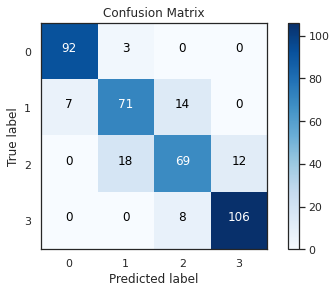

In [28]:
rf_confusion_mtx = confusion_matrix(y_test, rf_predict_test)
# true labels as rows, predicted labels as columns
plot_confusion_matrix(rf_confusion_mtx, range(4)) 

We also plot the top feature importances based on feature permutation.

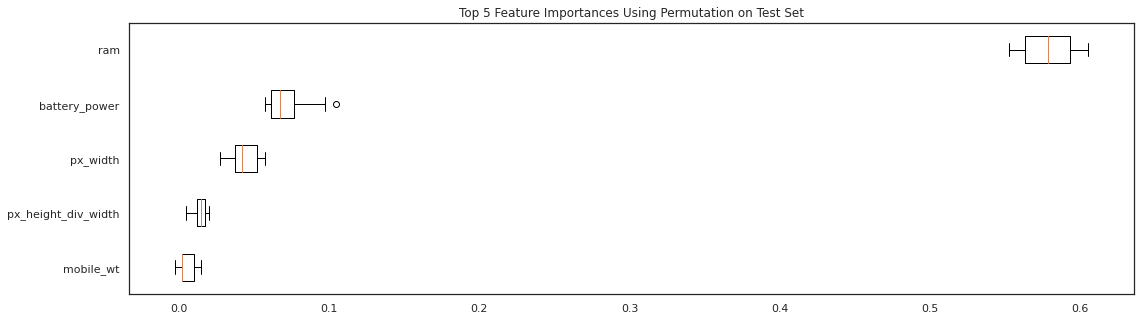

In [29]:
result = permutation_importance(rf_grid, X_test, y_test, n_repeats=10, n_jobs=2, random_state=0)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
fig.set_size_inches(18,5)
ax.boxplot(result.importances[sorted_idx[-5:]].T, vert=False, labels=X_test.columns[sorted_idx[-5:]])
ax.set_title("Top 5 Feature Importances Using Permutation on Test Set")
plt.show()

## CatBoost

CatBoost builds upon gradient boosted decision trees.

We first reverse the one-hot encoding for the generation features (one-hot encoding during preprocessing harms both the training speed and the resulting quality of the CatBoost model).

In [30]:
generation_features = ["two_g", "three_g", "four_g"]
X_train_cb = X_train.drop(generation_features, axis=1)
X_train_cb["generation"] = X_train[generation_features].idxmax(1)
X_test_cb = X_test.drop(generation_features, axis=1)
X_test_cb["generation"] = X_test[generation_features].idxmax(1)

In [31]:
X_train_cb.head()

,battery_power,blue,clock_speed,dual_sim,int_memory,m_dep,mobile_wt,n_cores,pc,px_width,ram,sc_h,talk_time,touch_screen,wifi,px_height_div_width,sc_w_div_h,fc_div_pc,generation
582,1232,0,2.9,1,24,0.3,169,5,17,809,1257,16,16,0,0,0.446230,0.625000,0.058824,four_g
159,1840,0,0.5,1,34,0.7,142,1,16,1545,1078,8,10,0,0,0.201294,0.000000,0.750000,two_g
1827,1692,0,2.1,0,2,0.9,106,1,17,1904,3779,9,7,1,1,0.997374,0.333333,0.235294,four_g
318,508,0,0.8,0,42,0.3,94,1,8,557,663,13,7,0,0,0.070018,0.923077,0.875000,four_g
708,977,1,2.8,1,35,0.6,165,2,15,1862,3714,19,10,1,1,0.806660,0.157895,0.133333,two_g


Again we tune the hyperparameters by performing a grid search.

In [32]:
cb_params = {'iterations': [100, 500, 1000],
             'max_depth': [4, 6, 8, 10],
             'random_seed': [0]
             }

In [34]:
cb = CatBoostClassifier()
cb_grid = GridSearchCV(estimator = cb, param_grid = cb_params)
cb_grid.fit(X_train_cb, y_train, cat_features = ["blue", "dual_sim", "touch_screen", "wifi", "generation"], verbose = 0)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f30c5a57d50>,
             param_grid={'iterations': [100, 500, 1000],
                         'max_depth': [4, 6, 8, 10], 'random_seed': [0]})

In [35]:
cb_grid.best_params_

{'iterations': 500, 'max_depth': 6, 'random_seed': 0}

In [36]:
cb_predict_train = cb_grid.predict(X_train_cb)
cb_predict_test = cb_grid.predict(X_test_cb)
print(f"Training accuracy of CatBoost classifier is {accuracy_score(y_train, cb_predict_train)}")
print(f"Test accuracy of CatBoost classifier is {accuracy_score(y_test, cb_predict_test)}")

Training accuracy of CatBoost classifier is 1.0
Test accuracy of CatBoost classifier is 0.9275


The CatBoost model performs much better than the random forest.

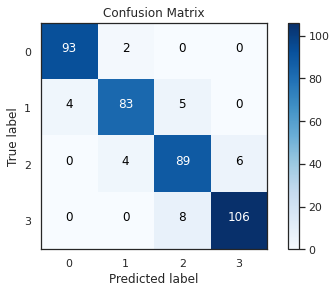

In [37]:
cb_confusion_mtx = confusion_matrix(y_test, cb_predict_test)
plot_confusion_matrix(cb_confusion_mtx, range(4))

Another way to calculate the top feature importances is using SHAP values.

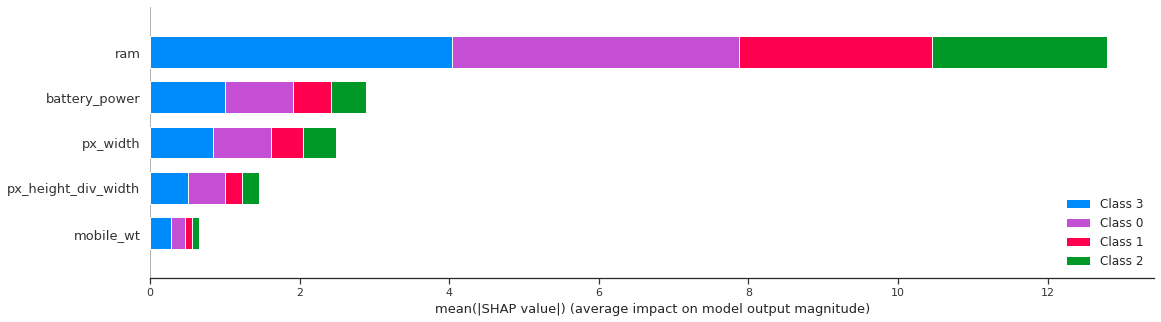

In [38]:
explainer = shap.TreeExplainer(cb_grid.best_estimator_)
shap_values = explainer.shap_values(Pool(X_test_cb, y_test, cat_features=["blue", "dual_sim", "touch_screen", "wifi", "generation"]))
# again we compute over the test set
shap.summary_plot(shap_values, X_test_cb, max_display = 5, plot_size = (18,5))

## Support vector machines

We standardize the numerical data in the training set. We also apply the transformation to the test set.

In [39]:
num_features = ["battery_power", "clock_speed", "int_memory", "m_dep",	"mobile_wt", "n_cores",	"pc",	"fc_div_pc", "px_width", "px_height_div_width",	"ram", "sc_h", "sc_w_div_h", "talk_time"]
scaler = StandardScaler()
numerical_data_train = scaler.fit_transform(X_train[num_features])
numerical_data_test = scaler.transform(X_test[num_features])
cont_features_scaled_train = pd.DataFrame(data=numerical_data_train, columns=num_features)
cont_features_scaled_test = pd.DataFrame(data=numerical_data_test, columns=num_features)

In [40]:
cat_features = ["blue", "dual_sim", "touch_screen", "wifi", "two_g", "three_g", "four_g"]
X_train_svc = pd.concat([cont_features_scaled_train, X_train[cat_features].reset_index(drop=True)], axis=1)
X_test_svc = pd.concat([cont_features_scaled_test, X_test[cat_features].reset_index(drop=True)], axis=1)
# all preprocessed inputs
X_train_svc.head()

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,fc_div_pc,px_width,px_height_div_width,ram,sc_h,sc_w_div_h,talk_time,blue,dual_sim,touch_screen,wifi,two_g,three_g,four_g
0,-0.001608,1.671035,-0.430667,-0.692543,0.852842,0.216380,1.183752,-1.039853,-1.042159,-0.255007,-0.786095,0.882404,0.565365,0.911171,0,1,0,0,0,0,1
1,1.374075,-1.270550,0.119443,0.693843,0.084708,-1.543255,1.018941,1.233714,0.655005,-1.103093,-0.952286,-1.032614,-1.588109,-0.183466,0,1,0,0,1,0,0
2,1.039205,0.690506,-1.640908,1.387036,-0.939471,-1.543255,1.183752,-0.459368,1.482833,1.653323,1.555428,-0.793236,-0.439589,-0.730784,0,0,1,1,0,0,1
3,-1.639756,-0.902852,0.559530,-0.692543,-1.280863,-1.543255,-0.299543,1.644891,-1.623253,-1.557637,-1.337588,0.164273,1.592407,-0.730784,0,0,0,0,0,0,1
4,-0.578580,1.548469,0.174453,0.347246,0.739044,-1.103346,0.854131,-0.794760,1.385984,0.992977,1.495079,1.600536,-1.044073,-0.183466,1,1,1,1,1,0,0


We first train an SVM model with a linear kernel.

In [41]:
linear_svc = SVC(kernel='linear', random_state=0)
linear_svc.fit(X_train_svc, y_train)

SVC(kernel='linear', random_state=0)

In [42]:
linear_svc_predict_train = linear_svc.predict(X_train_svc)
linear_svc_predict_test = linear_svc.predict(X_test_svc)
print(f"Training accuracy of linear SVM is {accuracy_score(y_train, linear_svc_predict_train)}")
print(f"Test accuracy of linear SVM  is {accuracy_score(y_test, linear_svc_predict_test)}")

Training accuracy of linear SVM is 0.966875
Test accuracy of linear SVM  is 0.9425


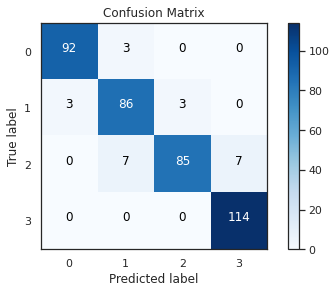

In [43]:
linear_svc_confusion_mtx = confusion_matrix(y_test, linear_svc_predict_test)
plot_confusion_matrix(linear_svc_confusion_mtx, range(4))

We train another SVM model with the Radial Basis Function (RBF) kernel.

In [44]:
rbf_svc = SVC(kernel='rbf', random_state=0)
rbf_svc.fit(X_train_svc, y_train)

SVC(random_state=0)

In [45]:
rbf_svc_predict_train = rbf_svc.predict(X_train_svc)
rbf_svc_predict_test = rbf_svc.predict(X_test_svc)
print(f"Training accuracy of rbf SVM is {accuracy_score(y_train, rbf_svc_predict_train)}")
print(f"Test accuracy of rbf SVM  is {accuracy_score(y_test, rbf_svc_predict_test)}")

Training accuracy of rbf SVM is 0.9875
Test accuracy of rbf SVM  is 0.905


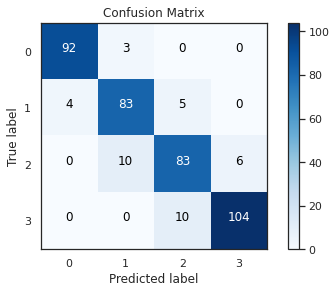

In [46]:
rbf_svc_confusion_mtx = confusion_matrix(y_test, rbf_svc_predict_test)
plot_confusion_matrix(rbf_svc_confusion_mtx, range(4))

The SVM with linear kernel yields better performance.